<a href="https://colab.research.google.com/github/rizwanasif/DL-RMD/blob/main/DL_RMD_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL-RMD: A geophysically constrained electromagnetic resistivity model database for deep learning applications (code demo)




This repository contains the weights and biases for the trained network using S-RMD in the paper [Paper Title](http://colab.research.google.com) to generate TEM forward responses for the tTEM system. The specific settings are available in the paper.

## Load required libraries and clone the github folder

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
!git clone https://github.com/rizwanasif/DL-RMD.git

## Load the network weights, biases, normalization values, and the test dataset by cloning the github repository

In [162]:
L1_W = np.loadtxt('/content/DL-RMD/L1_W.txt', delimiter=',')
L1_B = np.loadtxt('/content/DL-RMD/L1_B.txt', delimiter=',')
L2_W = np.loadtxt('/content/DL-RMD/L2_W.txt', delimiter=',')
L2_B = np.loadtxt('/content/DL-RMD/L2_B.txt', delimiter=',')
L3_W = np.loadtxt('/content/DL-RMD/L3_W.txt', delimiter=',')
L3_B = np.loadtxt('/content/DL-RMD/L3_B.txt', delimiter=',')
mu   = np.loadtxt('/content/DL-RMD/mu.txt', delimiter=',')
std  = np.loadtxt('/content/DL-RMD/std.txt', delimiter=',')
t    = np.loadtxt('/content/DL-RMD/t.txt', delimiter=',')
maxR = 3.301029995663981
minR = 0
test_resistivity = np.loadtxt('/content/DL-RMD/resistivity_Soften.txt', delimiter=',')
test_forwards    = np.loadtxt('/content/DL-RMD/forwards_Soften.txt', delimiter=',')


Use the network weights and biases for the forward pass 

In [163]:
time_start = time.time()
resistivity_n= np.log10(test_resistivity) - np.mean(maxR + minR)/2 ## resistivity normalization as Eq. (2)
nn_output2   = np.tanh(np.matmul(resistivity_n, L1_W) + L1_B)      ## first network layer 
nn_output1   = np.tanh(np.matmul(nn_output2, L2_W) + L2_B)         ## second network layer
nn_output    = np.matmul(nn_output1, L3_W) + L3_B                  ## last network layer
nn_output_dn = (nn_output * std) + mu                              ## denormalize network output by manipulating Eq. (3)
time_elapsed = time.time() - time_start
print('Time taken to generate ' + str(test_resistivity.shape[0]) + ' forwards' )
## relative error % between neural network forwards trained on S-RMD and the numerically computed forward responses using AarhusInv (free software for research)
rel_err = ((nn_output_dn - test_forwards) / test_forwards) * 100   

Time taken to generate 697 forwards


## Distribution of relative errors of the network trained on S-RMD (Figure 3)

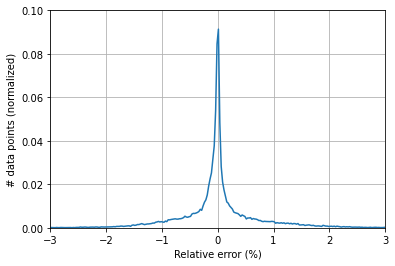

In [164]:
hist_edges = np.linspace(-3,3, 241)                                ## edges with spaing of 0.025 between -3 and +3 relative error
edges_ = hist_edges[1:] - (hist_edges[1]-hist_edges[0])/2;         ## center of edge for plotting
hist, bin_edges = np.histogram(rel_err.squeeze(), hist_edges)      ## get counts in each bins defined by hist_edges

plt.plot(edges_, hist/sum(hist))                                   ## plot the normalized values
plt.xlabel('Relative error (%)')
plt.ylabel('# data points (normalized)')
plt.ylim([0, 0.1])
plt.xlim([-3, 3])
plt.grid()

## Visual comparison of neural network forward response and the numerically computed forward response (Figure 4a)

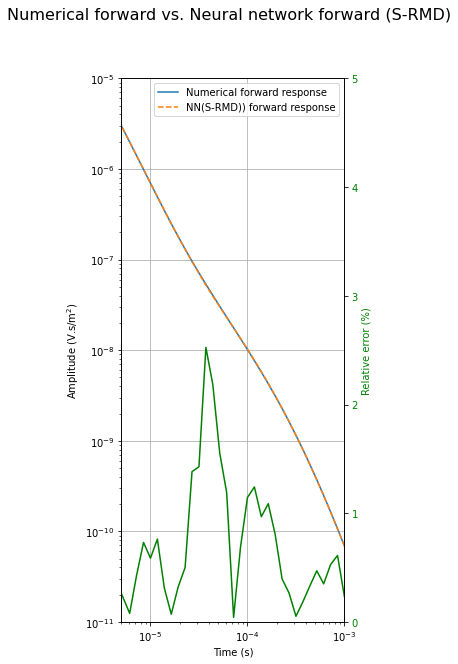

In [165]:
idx = 71
fig, ax1 = plt.subplots(figsize=(4, 10))
ax2 = ax1.twinx()

ax1.loglog(t, abs(test_forwards[idx,:]), label = 'Numerical forward response')
ax1.loglog(t, abs(nn_output_dn[idx,:]), '--', label = 'NN(S-RMD)) forward response')
ax2.semilogx(t, abs(rel_err[idx,:]), c = 'g')


ax1.set_ylim([1e-11, 1e-5])
ax2.set_ylim([0, 5])
ax2.set_xlim([5e-6, 1e-3])
ax1.grid()
ax1.legend()
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (V.s/m$^{2}$)')
ax2.set_ylabel('Relative error (%)', c= 'g')
ax2.tick_params(axis="y", labelcolor='g')
fig.suptitle('Numerical forward vs. Neural network forward (S-RMD)', fontsize = 16)
plt.show()
